In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

In [3]:
from brian2 import *

## Integrate-and-fire neuron model

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity 

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [4]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [5]:
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

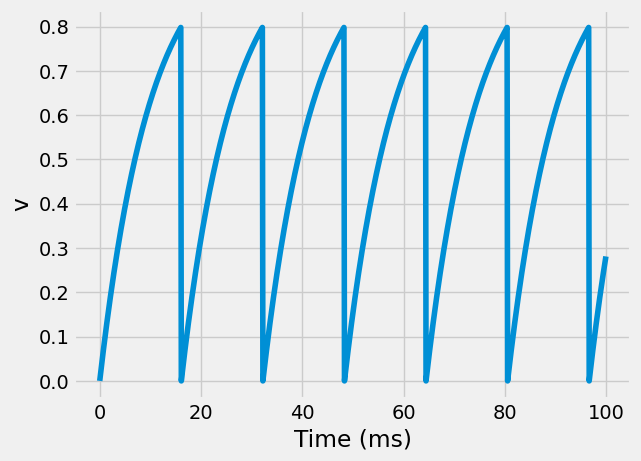

In [6]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it. 

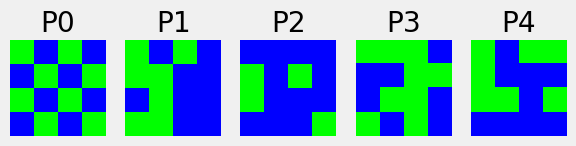

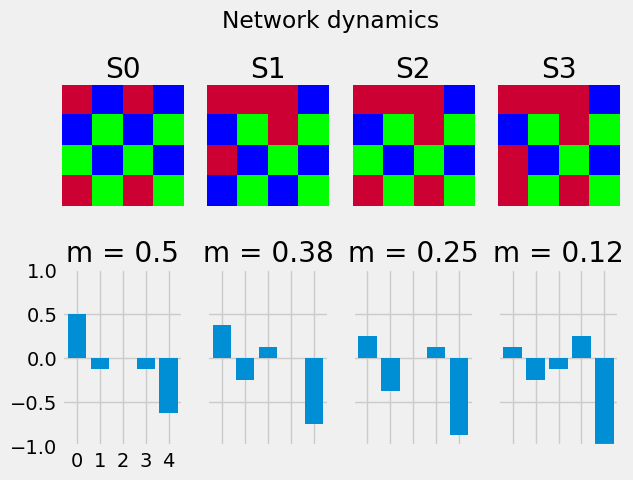

In [7]:
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Our own Hopfield network model

You will write your own code to build a Hopfield network. I am leaving sample expected results below as a guide. 

In [ ]:
plist = get_patterns(4,5)
#plot_tools.plot_pattern_list(plist)

cue = deepcopy(plist)

S = perturb_pattern(cue[0],3)
wghts = calculate_weights(plist, pattern_size)

state_list =[S]
#state_list.append(S)
#print(state_list)
#plot_tools.plot_pattern(S)
for i in range(3):
    state_list.append(network_evolution(S,wghts))
#    state_list.append(S)

plot_tools.plot_pattern_list(plist)
#print(state_list[0])
plot_tools.plot_pattern(state_list[0])
plot_tools.plot_state_sequence_and_overlap(state_list, plist, reference_idx=0, suptitle="Network dynamics")

## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of 
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points) 

# Q1)
### The following is the implementation of Hopfield Network

In [2]:
# importing all libraries required for the below codes
import numpy as np
import copy
import pandas as pd
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.datasets import mnist
from scipy.ndimage import interpolation
import random
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (6,4)

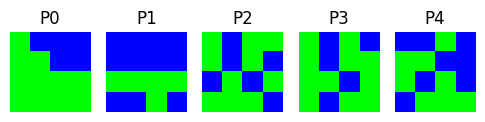

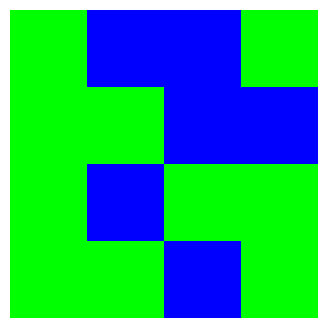

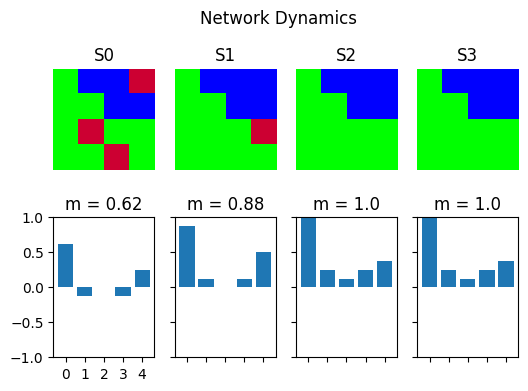

In [5]:
# cLass defined for implementing hopfield network model
class HopfieldNet:
    def __init__(self,pt_size): 
        self.pt_size = pt_size  
        self.num_neuro = pt_size**2 
        self.wt = None  
        self.pt = [] 
    
    def gen_patterns(self, num_pt): 
        self.pt = [np.random.choice([-1, 1], size=(self.pt_size, self.pt_size)) for z in range(num_pt)]
        self.compute_weights()

    def set_patterns(self, patterns):
        self.pt = patterns
        self.compute_weights()

    def compute_weights(self): 
        self.wt = np.zeros((self.num_neuro, self.num_neuro))
        for p in self.pt:
            flat_pt = p.flatten()
            self.wt += np.outer(flat_pt, flat_pt)
        np.fill_diagonal(self.wt, 0)
        self.wt = self.wt/len(self.pt)

    def perturb(self, pt_index, num_flips): 
        pat = self.pt[pt_index].copy()
        flat_index = np.random.choice(self.num_neuro, num_flips, replace=False)
        pat.flat[flat_index] *= -1
        return pat
    
    def update_state(self, state): 
        flat_st = state.flatten()
        activation = np.zeros(self.num_neuro)
        for i in range(self.num_neuro):
            activation[i] = np.sum(self.wt[i, :] * flat_st)
        return np.sign(activation).reshape(state.shape)
    
    def overlap(self, state): 
        overlaps = [np.mean(p * state) for p in self.pt]
        return overlaps
    
    def simulation(self,init_state,num_steps): 
        state_seq = [init_state]
        for x in range(num_steps):
            nextst = self.update_state(state_seq[-1])
            state_seq.append(nextst)
        return state_seq

def main(): 
    pattern_size = 4
    num_patterns = 5
    num_flips = 3
    num_steps = 3

    hopfield_net = HopfieldNet(pattern_size)
    hopfield_net.gen_patterns(num_patterns)
    cue = copy.deepcopy(hopfield_net.pt)
    S = hopfield_net.perturb(0, num_flips)
    wghts = hopfield_net.wt
    state_list = [S]
    for i in range(num_steps):
        S = hopfield_net.update_state(state_list[-1])
        state_list.append(S)

    plot_tools.plot_pattern_list(hopfield_net.pt)
    plot_tools.plot_pattern(state_list[0])
    plot_tools.plot_state_sequence_and_overlap(state_list, hopfield_net.pt, reference_idx=0, suptitle="Network Dynamics")

if __name__ == "__main__":
    main()

# Q2)
## A) Informativeness Of Cue: 
Here we are checking the variation of accuracy with number of flips. Additionally, have included variation of number of patterns and sizes in the graphs to add more details.

In [6]:
def compute_accuracy(original, retrieved): 
    correct_matches = np.sum(original == retrieved)
    total_elements = original.size
    return correct_matches / total_elements

### A.1) Variation in number of flips and number of patterns

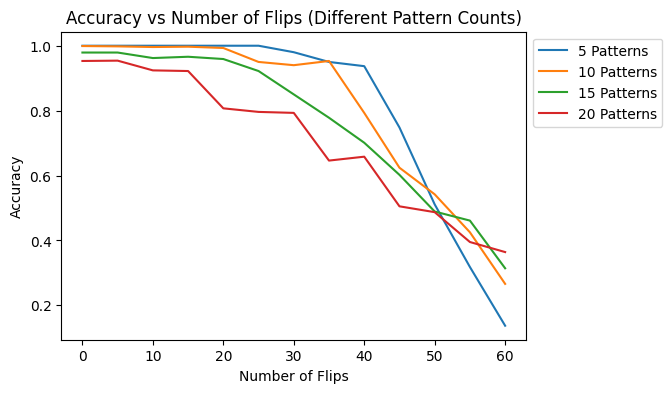

In [7]:
acc_res = [] 

for pat_count in range(5, 21, 5):
    flip_acc = np.zeros(13) 
    for i in range(10):  
        hopfield_net = HopfieldNet(10)
        hopfield_net.gen_patterns(pat_count)
        for flip_count in range(0,61, 5):  
            pert_state = hopfield_net.perturb(0,flip_count)
            for j in range(5):
                pert_state = hopfield_net.update_state(pert_state)
            flip_acc[flip_count//5] += compute_accuracy(hopfield_net.pt[0],pert_state)
    acc_res.append(flip_acc/10)

o, p = plt.subplots()
for idx, acc in enumerate(acc_res):
    flip_values = np.arange(0, 65, 5) 
    p.plot(flip_values, acc, label=f'{(idx + 1) * 5} Patterns')
p.set_xlabel('Number of Flips')
p.set_ylabel('Accuracy')
p.set_title('Accuracy vs Number of Flips (Different Pattern Counts)')
p.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


### The accuracy of Hopfield network reduces with number of Flip, and also decreases more gradually for more number of patterns.

### A.2) Variation in number of flips and size of patterns

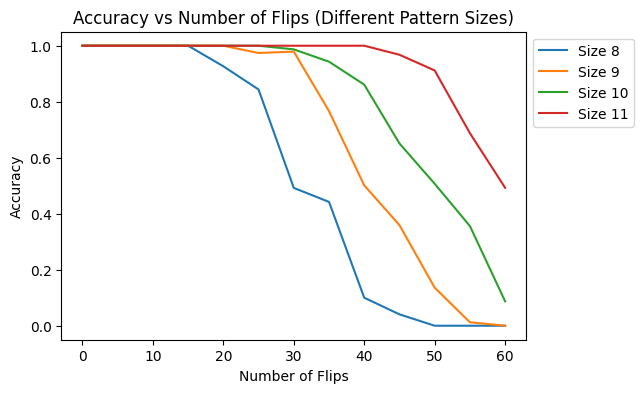

In [8]:
acc_size = []
for size in range(8,12):
    acc_flips = np.zeros(13)
    for i in range(10):  
        network = HopfieldNet(size)
        network.gen_patterns(5)
        weight_matrix = network.wt
        for flip_count in range(0,61,5):
            altered_pattern = network.perturb(0, flip_count)
            for j in range(5):
                altered_pattern = network.update_state(altered_pattern)
            acc_flips[flip_count//5]+= compute_accuracy(network.pt[0], altered_pattern)
    acc_size.append(acc_flips/10)
    
o, p = plt.subplots()
for index, acc in enumerate(acc_size):
    flip_values = np.arange(0, 65, 5)
    p.plot(flip_values, acc, label=f'Size {index + 8}')
p.set_xlabel('Number of Flips')
p.set_ylabel('Accuracy')
p.set_title('Accuracy vs Number of Flips (Different Pattern Sizes)')
p.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()


### The accuracy decreases rapidly at lower number of flips for a smaller size of pattern

# B) Number of other patterns stored in network

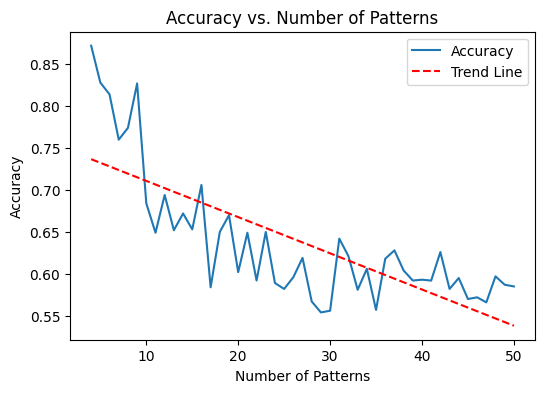

In [9]:
acc_res = np.zeros(47)
pat_range = range(4, 51)

for num_pat in pat_range:
    for i in range(10):
        network = HopfieldNet(10)
        network.gen_patterns(num_pat)
        init_patterns = copy.deepcopy(network.pt)
        weight_matrix = network.wt
        altered_pattern = network.perturb(0, 40)
        for j in range(5):
            altered_pattern = network.update_state(altered_pattern)
        acc_index = num_pat - 4
        acc_res[acc_index] += compute_accuracy(network.pt[0], altered_pattern)

avg_acc = acc_res / 10
o, p = plt.subplots()
pat_counts = list(pat_range)
p.plot(pat_counts, avg_acc, label='Accuracy')
z = np.polyfit(pat_counts, avg_acc, 1)  
p_trend = np.poly1d(z)
p.plot(pat_counts, p_trend(pat_counts), linestyle='--', color='r', label='Trend Line')

p.set_xlabel('Number of Patterns')
p.set_ylabel('Accuracy')
p.set_title('Accuracy vs. Number of Patterns')
p.legend(loc='best')
plt.show()

### The accuracy decreases with increase in number of patterns

# C) The size of network

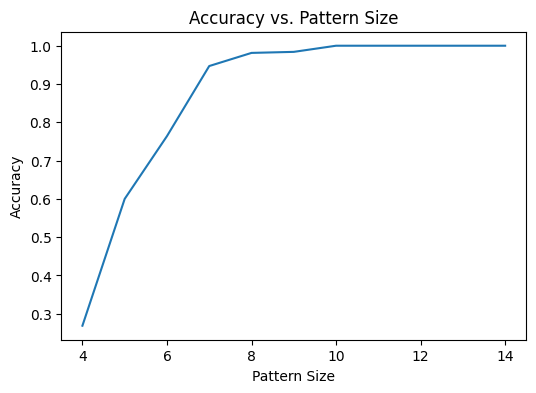

In [10]:
acc_size = np.zeros(11)
pat_sizes = range(4, 15)

for size in pat_sizes:
    for i in range(10):  
        hopfield_network = HopfieldNet(size)
        hopfield_network.gen_patterns(6)
        patterns = copy.deepcopy(hopfield_network.pt)
        weight_matrix = hopfield_network.wt
        pert_state = hopfield_network.perturb(0, 12)
        for j in range(5):
            pert_state = hopfield_network.update_state(pert_state)
        index = size - 4
        acc_size[index] += compute_accuracy(hopfield_network.pt[0], pert_state)

avg_size = acc_size / 10
o, p = plt.subplots()
sizes = list(pat_sizes)
p.plot(sizes, avg_size)
p.set_xlabel('Pattern Size')
p.set_ylabel('Accuracy')
p.set_title('Accuracy vs. Pattern Size')
plt.show()


### Accuracy increases with increase in size of pattern

# Q3) 
This is a simple function used to convert MNIST data into Hopfield patterns

In [11]:
def img_to_pat(image):
        pattern = np.where(image >= 127, 1, -1)
        return pattern
    
def mnist_to_hopfield_patterns():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train_patterns = [img_to_pat(image) for image in train_images]
    test_patterns = [img_to_pat(image) for image in test_images]
    return (train_patterns, train_labels), (test_patterns, test_labels)

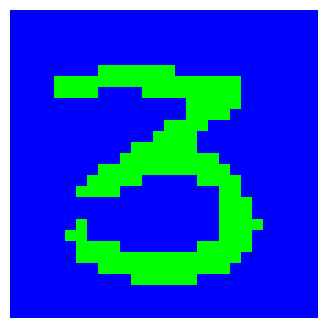

In [12]:
(train_patterns, train_labels), (test_patterns, test_labels) = mnist_to_hopfield_patterns()

random_index = random.randint(0, len(train_patterns) - 1)
random_pattern = train_patterns[random_index]
random_label = train_labels[random_index]

plot_tools.plot_pattern(random_pattern)

# Q4)
In this question, I have coded a MNIST multi-classifier using my earlier defined Hopfield Network. Here I have written a more detailed and complex function for conversion of MNIST data into Hopfield pattern. It also includes preprocessing like Deskew Transformation and resizing. The code has two main functions. First one is for trying to predict the label of single test pattern and plotting the results just like in Q1. The second main function involves calculating accuracy of prediction of test data over the entire MNIST test data set, whose size is 10000! For defining classes for the multi classifier, we have used data from train data set(of size 60000), which is preprocessed averaged patterns over 5 images having same labels for every digit, that is 10 class patterns. The final results are in the output of these executed cells. 

In [13]:
# function to apply deskew transformation over data
def deskew(img):
    a, b = np.mgrid[:img.shape[0], :img.shape[1]]
    m = img.sum()
    x_mean = (a * img).sum() / m
    y_mean = (b * img).sum() / m
    p = ((a - x_mean) * (b - y_mean) * img).sum() / m
    q = ((a - x_mean) ** 2 * img).sum() / m
    skew = p / q
    affine = np.array([[1, skew], [0, 1]])
    ocenter = np.array(img.shape) / 2.0
    offset = np.array([x_mean, y_mean]) - affine @ ocenter
    return interpolation.affine_transform(img, affine, offset=offset)

def to_binary(img):
    cropped = img[7:21, 7:21]
    return np.where(cropped > 127, 1, -1).reshape(-1, 14)

# for mnist_main2() function, returning preprocessed train and test data
def prep():
    (train_X, train_Y), (test_X, test_Y) = mnist.load_data()
    tr_pat, tr_lab = [], []
    te_pat, te_lab = [], []
    for num in range(10):
        tr_idx = [i for i, label in enumerate(train_Y) if label == num]
        samp_tr = random.sample(tr_idx, 5)
        dig_pat = [to_binary(deskew(train_X[idx])) for idx in samp_tr]
        avg_pat = np.mean(dig_pat, axis=0)
        tr_pat.append(avg_pat)
        tr_lab.append(num)
    for idx in range(len(test_X)):
        te_pat.append(to_binary(deskew(test_X[idx])))
        te_lab.append(test_Y[idx])
    return (tr_pat, tr_lab), (te_pat, te_lab)

def to_binary2(img):
    return np.where(img > 127, 1, -1)

# for mnist_main1() function
def prep2():
    (train_X, train_Y), (test_X, test_Y) = mnist.load_data()
    tr_pat, tr_lab = [], []
    for num in range(10):
        tr_idx = [i for i, label in enumerate(train_Y) if label == num]
        samp_tr = np.random.choice(tr_idx)
        dig_pat = to_binary2(deskew(train_X[samp_tr]))
        tr_pat.append(dig_pat)
        tr_lab.append(num)
    test_idx = np.random.randint(len(test_X))
    te_pat = to_binary2(deskew(test_X[test_idx]))
    te_lab = test_Y[test_idx]
    return (tr_pat, tr_lab), (te_pat, te_lab)

def sim(p1, p2):
    return np.dot(p1.flatten(), p2.flatten()) / p1.size

def predict(test_pat, tr_pat, tr_lab):
    max_sim, pred = -1, -1
    for i, ref_pat in enumerate(tr_pat):
        curr_sim = sim(test_pat, ref_pat)
        if curr_sim > max_sim:
            max_sim = curr_sim
            pred = tr_lab[i]
    return pred
    
def plot_pattern_list(patterns, title="Patterns"):
    fig, axes = plt.subplots(1, len(patterns), figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(patterns[i], cmap='binary')
        ax.set_title(f'P{i}')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_state_sequence_and_overlap(state_seq, patterns, suptitle="Network Dynamics"):
    num_steps = len(state_seq)
    fig, axes = plt.subplots(2, num_steps, figsize=(15, 6))
    for i in range(num_steps):
        axes[0, i].imshow(state_seq[i], cmap='binary')
        axes[0, i].set_title(f'S{i}')
        axes[0, i].axis('off')
        overlaps = [np.mean(p * state_seq[i]) for p in patterns]
        axes[1, i].bar(range(len(overlaps)), overlaps)
        axes[1, i].set_ylim(-1, 1)
        axes[1, i].set_title(f'm = {np.max(overlaps):.2f}')
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_155417/255966069.py:13: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  return interpolation.affine_transform(img, affine, offset=offset)


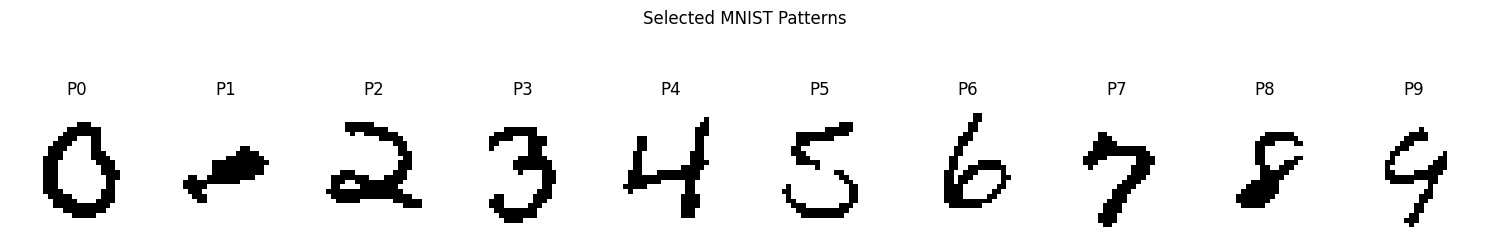

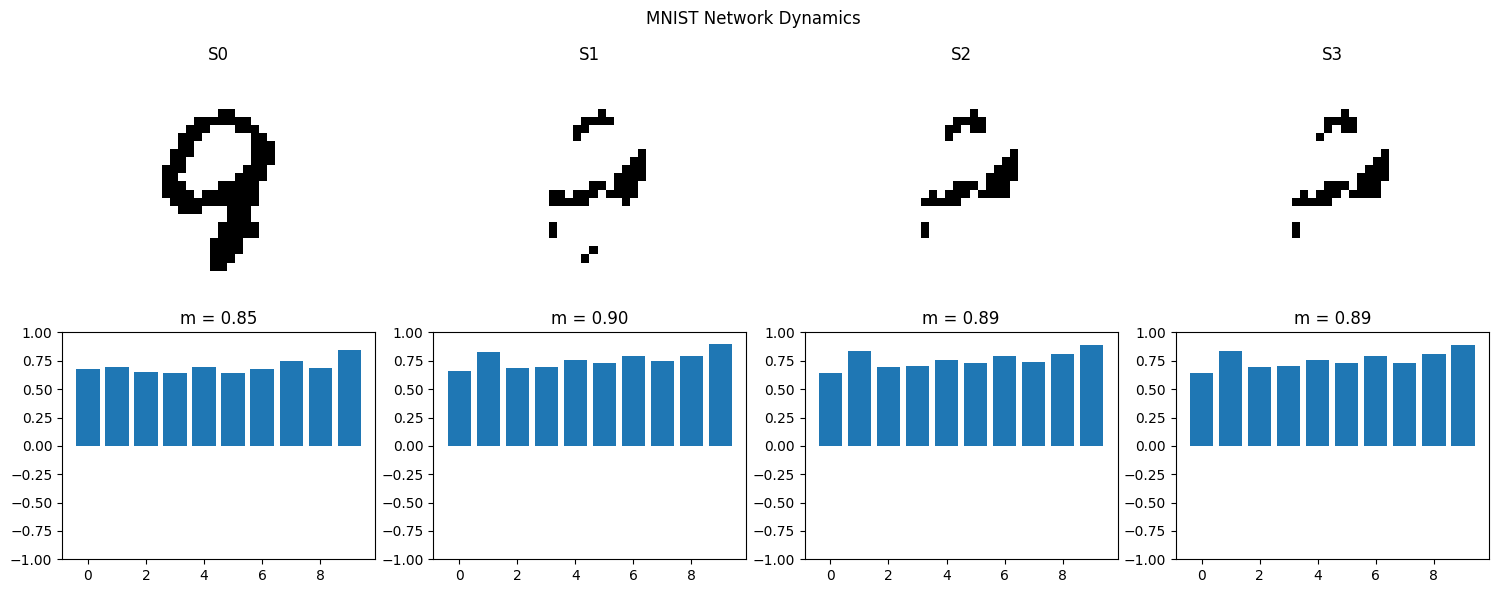

Actual label: 9
Predicted label: 9


In [18]:
def mnist_main1(): # to execute the pattern prediction of one test data, and plotting results
    (tr_pat, tr_lab), (te_pat, te_lab) = prep2()
    hopfield_net = HopfieldNet(28)
    hopfield_net.set_patterns(tr_pat)
    
    plot_pattern_list(tr_pat, "Selected MNIST Patterns")
    num_steps = 3
    state_seq = hopfield_net.simulation(te_pat, num_steps)
    plot_state_sequence_and_overlap(state_seq, tr_pat, "MNIST Network Dynamics")
    
    final_state = state_seq[-1]
    overlaps = hopfield_net.overlap(final_state)
    predicted_label = tr_lab[np.argmax(overlaps)]
    print(f"Actual label: {te_lab}")
    print(f"Predicted label: {predicted_label}")
    return te_lab, predicted_label

if __name__ == "__main__":
    mnist_main1()

In [20]:
# main function for calculating accuracy and Fscore for entire test set
def mnist_main2():
    (tr_pat, tr_lab), (te_pat, te_lab) = prep()
    hop_net = HopfieldNet(14)
    hop_net.set_patterns(tr_pat)

    preds = []
    for pat in te_pat:
        ev_pat = hop_net.simulation(pat, num_steps=1)[-1]
        preds.append(predict(ev_pat, tr_pat, tr_lab))
    print('Precision table:\n')
    metrics = {
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Micro': [
        round(precision_score(te_lab, preds, average='micro'), 4),
        round(recall_score(te_lab, preds, average='micro'), 4),
        round(f1_score(te_lab, preds, average='micro'), 4)
    ],
    'Macro': [
        round(precision_score(te_lab, preds, average='macro'), 4),
        round(recall_score(te_lab, preds, average='macro'), 4),
        round(f1_score(te_lab, preds, average='macro'), 4)
    ],
    'Weighted': [
        round(precision_score(te_lab, preds, average='weighted'), 4),
        round(recall_score(te_lab, preds, average='weighted'), 4),
        round(f1_score(te_lab, preds, average='weighted'), 4)
    ]
    }
    df = pd.DataFrame(metrics)
    print(df)
    
    print('\nHopfield Classification Report\n\n', classification_report(te_lab, preds))
    print('\n Final Accuracy:', round(accuracy_score(te_lab, preds), 4))

# Entry point
if __name__ == "__main__":
    mnist_main2()

/tmp/ipykernel_155417/255966069.py:13: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  return interpolation.affine_transform(img, affine, offset=offset)


Precision table:

      Metric   Micro   Macro  Weighted
0  Precision  0.3721  0.5579    0.5528
1     Recall  0.3721  0.3596    0.3721
2   F1 Score  0.3721  0.3227    0.3259

Hopfield Classification Report

               precision    recall  f1-score   support

           0       0.81      0.56      0.66       980
           1       0.34      0.99      0.51      1135
           2       0.76      0.13      0.23      1032
           3       0.69      0.20      0.31      1010
           4       0.76      0.22      0.34       982
           5       0.57      0.05      0.09       892
           6       0.78      0.40      0.53       958
           7       0.21      0.91      0.34      1028
           8       0.45      0.13      0.21       974
           9       0.21      0.01      0.01      1009

    accuracy                           0.37     10000
   macro avg       0.56      0.36      0.32     10000
weighted avg       0.55      0.37      0.33     10000


 Final Accuracy: 0.3721


### The final accuracy of MNIST classifier using Hopfield Network lies between 20% to 40% and F-score between 0.25 to 0.40. This turns out to be less when compared to Classical and  Deep Learning networks that give accuracy upto 99%. 

# Advantages of Hopfield Model:
### a) Store patterns directly, so useful in retrieving and correcting a pattern.
### b) Simple to understand and implement.
### c) requires less training time compared to other heavy models

# Disadvantages of Hopfield Model:
### a) Limited capacity to store patterns and data(since it deals with binary patterns)
### b) Less accuracy while predicting/correcting patterns.
### c) It is not designed to generalize beyond patterns stored in memory.

# References:
1) Deskew: https://stackoverflow.com/questions/43577665/deskew-mnist-images
2) Classification Report: https://www.geeksforgeeks.org/compute-classification-report-and-confusion-matrix-in-python/
3) Precision Score: https://stackoverflow.com/questions/55740220/macro-vs-micro-vs-weighted-vs-samples-f1-score
4) Research Paper: https://iopscience.iop.org/article/10.1088/1757-899X/862/5/052048